# IFT888 - Question 1 partie 1

* Entraîner un réseau en utilisant la cross-entropie comme fonction de perte
* Entraîner un réseau en utilisant l'entropie comme fonction de perte
* Entraîner un réseau en utilisant l'information comme fonction de perte

Le code de base est tiré du TP4 du cours IFT603 puis adapté pour les besoins de ces démonstrations.
Le "blog post" https://mattpetersen.github.io/softmax-with-cross-entropy a été d'une grande aide pour dériver le softmax et l'obtenir sous sa forme matricielle.

Premièrement, un peu de "poutine" pour charger les librairies et les données

In [189]:
'''
 Imporation des bibliothèques python générales
'''
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.datasets import make_gaussian_quantiles

'''
 Imporation des bibliothèques spécifiques au devoir
'''
import utils
from two_layer_classifier import TwoLayerClassifier

%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
samples_per_class = 250
num_classes = 4

X_, y_ = make_gaussian_quantiles(n_features=2, n_classes=num_classes, n_samples=num_classes * samples_per_class)


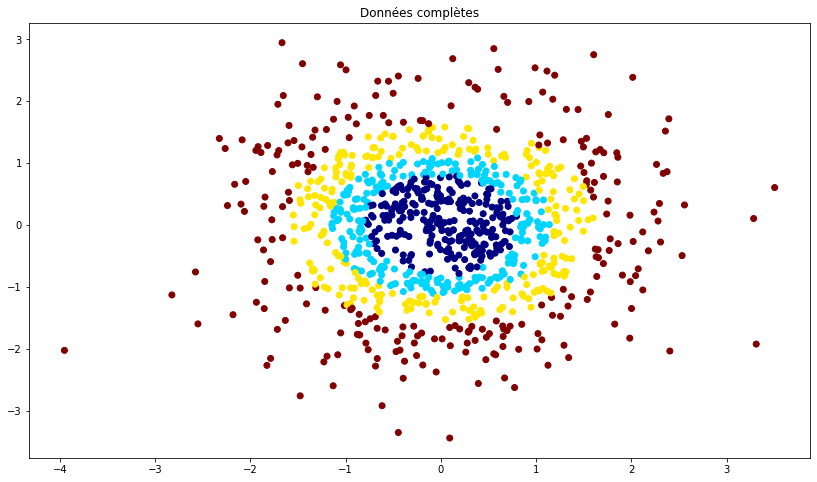

In [191]:
plt.scatter(X_[:, 0], X_[:, 1], c=y_, cmap='jet')
plt.title('Données complètes')
plt.show()

In [192]:
train_proportion = 0.5
val_proportion = 0.2
num_train = int(len(X_) * train_proportion)
num_val = int(len(X_) * val_proportion)

np.random.seed(0)
idx = np.random.permutation(len(X_))

train_idx = idx[:num_train]
val_idx = idx[num_train:num_train + num_val]
test_idx = idx[num_train + num_val:]

X_train = X_[train_idx]
y_train = y_[train_idx]
X_val = X_[val_idx]
y_val = y_[val_idx]
X_test = X_[test_idx]
y_test = y_[test_idx]

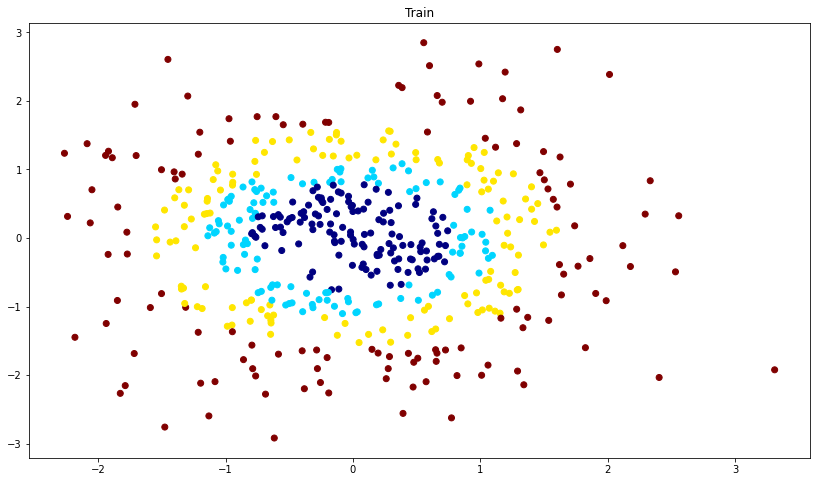

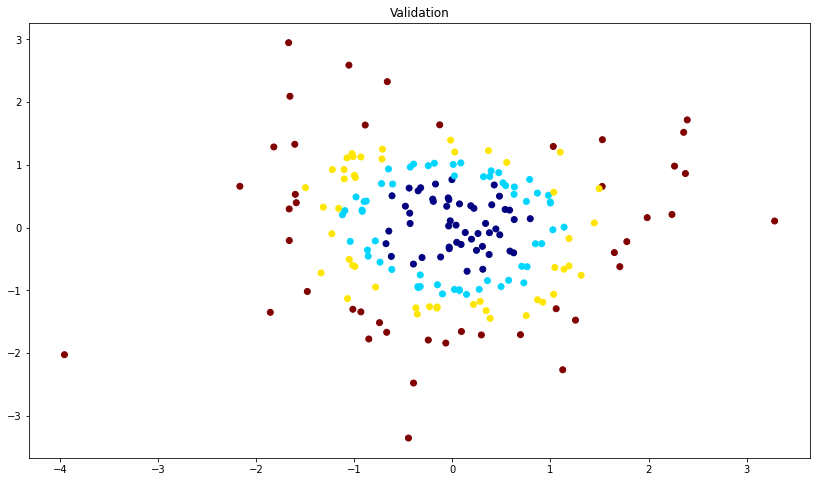

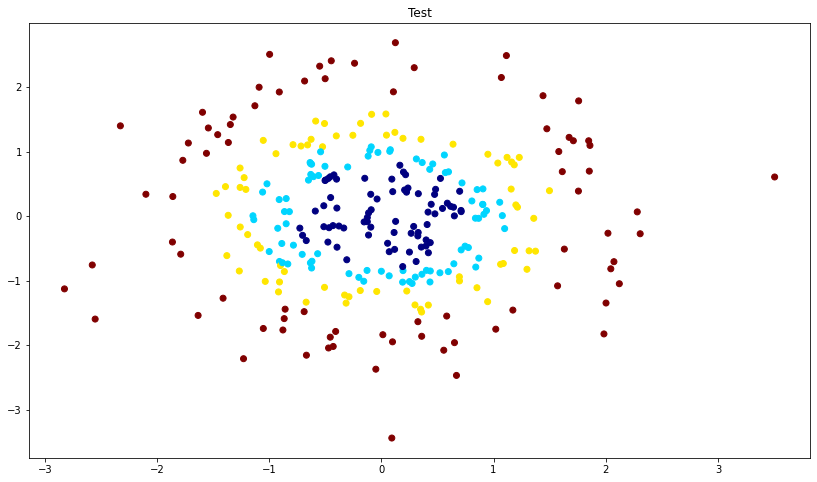

In [193]:
# Affichons maintenant les données d'entraînement, de validation et de test.
plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='jet')
plt.title('Train')
plt.show()

plt.figure()
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap='jet')
plt.title('Validation')
plt.show()

plt.figure()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='jet')
plt.title('Test')
plt.show()

# Entraîner avec la cross entropie

Commençons d'abord par définir les fonctions de pertes et leurs composantes respectives

La cross-entropy $E_{CE}$ est définie par 

$$E_{CE} = -\sum_c t_c \log y_c(x) = -T \log Y(x)$$

avec $T = (t_0, ..., t_c, ..., t_{C-1})$

Pour mettre à jour les poids $W$ dans la bonne direction, il est nécessaire de dériver $E_{CE}$ par rapport à $W$.

$$\frac{\partial E_{CE}}{\partial W} = \frac{\partial E_{CE}}{\partial Y(x)}\frac{\partial Y(x)}{\partial f(x)}\frac{\partial f(x)}{\partial W},$$

avec 

$$Y(x) = (y_0(x), ..., y_c(x), ..., y_{C-1}(x)) = (\frac{e^{f(x)_0}}{\sum_{c'} e^{f(x)_{c'}}}, ...,\frac{e^{f(x)_c}}{\sum_{c'} e^{f(x)_{c'}}}, ...,\frac{e^{f(x)_{C-1}}}{\sum_{c'} e^{f(x)_{c'}}})$$

$$f(x)_c = W_c^T x$$

Il faut donc trouver les composantes $\frac{\partial E_{CE}}{\partial Y(x)}$, $\frac{\partial Y(x)}{\partial f(x)}$ et $\frac{\partial f(x)}{\partial W}$.


Pour l'erreur, c'est assez simple:

$$\begin{aligned}
    \frac{\partial E_{CE}}{\partial Y(x)} &= \frac{\partial -T \log Y(x)}{\partial Y(x)} \\
                                          &= -\frac{T}{Y(x)}
  \end{aligned}
$$

Pour le softmax, les choses se corsent un peu. Pour des raisons qui deviendront apparentes plus tard, nous devrons obtenir la forme matricielle du jacobien $J_f(Y)$ plutôt que la forme par cas telle qu'elle est généralement utilisée. En effet, puisque le softmax est une opération $\mathbb{R}^{C-1} \rightarrow \mathbb{R}^{C-1}$, $J_f(Y)$ prend la forme d'une matrice $C-1 \times C-1$ 

$$J_f(Y) = \begin{bmatrix}
J_{i,j} = \frac{\partial y(x)_i}{\partial f(x)_j} 
\end{bmatrix}, i = 0...C-1; j = 0...C-1  $$

La dérivée partielle devra donc être déterminée en deux parties: lorsque $i = j$ et lorsque $i \neq j$.

Pour $i = j$:

$$\begin{aligned}
    \frac{\partial y(x)_i}{\partial f(x)_j}  &= \frac{\partial \frac{e^{f(x)_i}}{\sum_{j} e^{f(x)_{cj}}}}{f_j(x)} \\
                                             & = y_i(x) - y_j(x)^2
  \end{aligned}$$
  
Pour $i \neq j$:

$$\begin{aligned}
    \frac{\partial y(x)_i}{\partial f(x)_j}  &= \frac{\partial \frac{e^{f(x)_i}}{\sum_{j} e^{f(x)_{cj}}}}{f_j(x)} \\
                                             & = -y_i(x)y_j(x)
  \end{aligned}$$
  
On obtient donc la matrice

$$ J_f(Y) =
\begin{bmatrix}
y_0(x) - y_0(x)^2 & -y_0(x)y_1(x)     & ...    & -y_0(x)y_{C-1}(x)     \\
-y_1(x)y_0(x)     & y_1(x) - y_1(x)^2 & ...    & -y_1(x)y_{C-1}(x)     \\
\vdots            & ...               & \ddots & \vdots                \\
-y_{C-1}(x)y_0(x) & -y_{C-1}(x)y_1(x) & ...    & -y_{C-1}(x)y_{C-1}(x) \\
\end{bmatrix} = I \cdot Y^T - Y^TY = \frac{\partial Y(x)}{\partial f(x)}.
$$

Finalement,

$$\frac{\partial f(x)}{\partial W} = \frac{\partial W^Tx}{\partial W} = x$$

Ainsi, nous pouvons obtenir la dérivée de la cross-entropie par rapport aux poids

$$ \frac{\partial E_{CE}}{\partial W} = -\frac{T}{Y(x)} \cdot J_f(Y) \cdot x $$


Maintenant, implémentons ceci et vérifions que ça fonctionne:

In [194]:
""" Inspired by https://math.stackexchange.com/questions/2843505/derivative-of-softmax-without-cross-entropy # noqa E501
"""

def dloss_chain(d1, d2):
    return np.dot(d1, d2)

def cross_entropy(scores, t):
    return np.sum(-t * np.log(scores + 1e-10))

def cross_entropy_derivative(prob, t):
    return -t/prob

def softmax(scores):
    # For numerical stability. Does not change the prediction.
    scores -= np.max(scores)
    scores_exp = np.exp(scores)
    sum_exp = np.sum(scores_exp)
    class_prob = scores_exp / sum_exp
    return class_prob

def softmax_derivatives(softmax):
    # Jacobian of the softmax.
    # Usually represented using kroenecker delta, the full jacobian allows
    # for chain derivation
    s = softmax.reshape(-1, 1)
    return np.diagflat(s) - np.dot(s, s.T)

def cross_entropy_loss(self, scores, y):
    # y is encoded as a one-hot vector
    t = np.zeros(len(scores))
    t[y] = 1.

    probs = softmax(scores)
    loss = cross_entropy(probs, t)

    # "Analytical derivation
    dloss_dscores_analytical = probs - t

    # Chain derivation
    # −𝑇𝑌(𝑥)
    dcross_dsoft = cross_entropy_derivative(probs, t)
    # 𝐽𝑓(𝑌)
    dsoft_dscores = softmax_derivatives(probs)
    # −𝑇𝑌(𝑥)⋅𝐽𝑓(𝑌)
    dloss_dscores = dloss_chain(
        dcross_dsoft, dsoft_dscores)

    # Test to make sure chain derivation works
    assert np.allclose(dloss_dscores, dloss_dscores_analytical)

    # Regularization cost
    for w in zip(self.parameters):
        loss += 0.5 * self.l2_reg * np.sum(np.square(w))

    return loss, dloss_dscores

Commençons avec quelques **Sanity checks** pour s'assurer que l'entraînement avec la cross-entropy fonctionne correctement

In [195]:
num_hidden_neurons = 20
model = TwoLayerClassifier(X_train, y_train, X_val, y_val, cross_entropy_loss,
                           num_features=2, num_hidden_neurons=num_hidden_neurons, num_classes=num_classes)

# Vérifier que la sortie du réseau initialisé au hasard donne bien une prédiction égale pour chaque classe
num_hidden_neurons = 10
model = TwoLayerClassifier(X_train, y_train, X_val, y_val, cross_entropy_loss,
                           num_features=2, num_hidden_neurons=num_hidden_neurons, num_classes=num_classes)

# 2. Appeler la fonction qui calcule l'accuracy et la loss moyenne pour l'ensemble des données d'entraînement
_, loss = model.global_accuracy_and_loss(X_train,y_train,0)

# 3. Comparer au résultat attendu
loss_attendu = -np.log(1.0/num_classes) # résultat aléatoire attendu soit -log(1/nb_classes)
print('Sortie: {}  Attendu: {}'.format(loss, loss_attendu))
if abs(loss - loss_attendu) > 0.05:
    print('ERREUR: la sortie de la fonction est incorrecte.')
else:
    print('SUCCÈS')

Sortie: 1.3932263102828293  Attendu: 1.3862943611198906
SUCCÈS


In [196]:
# Vérifier que le fait d'augmenter la régularisation L2 augmente également la loss
for l2_r in np.arange(0,2,0.1):
    _, loss = model.global_accuracy_and_loss(X_train,y_train, l2_r)
    print('l2_reg= {:.4f} >> Loss/accuracy d\'entraînement : {:.3f}'.format(l2_r,loss))

l2_reg= 0.0000 >> Loss/accuracy d'entraînement : 1.393
l2_reg= 0.1000 >> Loss/accuracy d'entraînement : 1.419
l2_reg= 0.2000 >> Loss/accuracy d'entraînement : 1.444
l2_reg= 0.3000 >> Loss/accuracy d'entraînement : 1.469
l2_reg= 0.4000 >> Loss/accuracy d'entraînement : 1.495
l2_reg= 0.5000 >> Loss/accuracy d'entraînement : 1.520
l2_reg= 0.6000 >> Loss/accuracy d'entraînement : 1.546
l2_reg= 0.7000 >> Loss/accuracy d'entraînement : 1.571
l2_reg= 0.8000 >> Loss/accuracy d'entraînement : 1.597
l2_reg= 0.9000 >> Loss/accuracy d'entraînement : 1.622
l2_reg= 1.0000 >> Loss/accuracy d'entraînement : 1.647
l2_reg= 1.1000 >> Loss/accuracy d'entraînement : 1.673
l2_reg= 1.2000 >> Loss/accuracy d'entraînement : 1.698
l2_reg= 1.3000 >> Loss/accuracy d'entraînement : 1.724
l2_reg= 1.4000 >> Loss/accuracy d'entraînement : 1.749
l2_reg= 1.5000 >> Loss/accuracy d'entraînement : 1.775
l2_reg= 1.6000 >> Loss/accuracy d'entraînement : 1.800
l2_reg= 1.7000 >> Loss/accuracy d'entraînement : 1.825
l2_reg= 1.

In [197]:
# Vérification: Vous devez pouvoir faire du surapprentissage sur quelques échantillons.
# Si l'accuracy reste faible, votre implémentation a un bogue.
n_check = 5
X_check = X_train[:n_check]
y_check = y_train[:n_check]
model = TwoLayerClassifier( X_check, y_check, X_val, y_val, cross_entropy_loss,
    num_features=2, num_hidden_neurons=num_hidden_neurons, num_classes=num_classes
)

loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=100, lr=0.1, l2_reg=0.0)
print('Accuracy d\'entraînement, devrait être 1.0: {:.3f}'.format(accu_train_curve[-1]))
if accu_train_curve[-1] < 0.98:
    print('ATTENTION: L\'accuracy n\'est pas 100%.')
    utils.plot_curves(loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve)
else:
    print('SUCCÈS')

Accuracy d'entraînement, devrait être 1.0: 1.000
SUCCÈS


In [198]:
# Vérifier que le fait d'entraîner avec une régularisation L2 croissante augmente la loss et, éventuellement, diminue l'accuracy
for l2_r in np.arange(0,1,0.1):
    loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=200, lr=0.01, l2_reg=l2_r)
    print('l2_reg= {:.4f} >> Loss/accuracy d\'entraînement : {:.3f} {:.3f}'.format(l2_r,loss_train_curve[-1],accu_train_curve[-1]))


l2_reg= 0.0000 >> Loss/accuracy d'entraînement : 0.706 0.800
l2_reg= 0.1000 >> Loss/accuracy d'entraînement : 1.167 0.600
l2_reg= 0.2000 >> Loss/accuracy d'entraînement : 1.238 0.400
l2_reg= 0.3000 >> Loss/accuracy d'entraînement : 1.283 0.600
l2_reg= 0.4000 >> Loss/accuracy d'entraînement : 1.301 0.600
l2_reg= 0.5000 >> Loss/accuracy d'entraînement : 1.312 0.400
l2_reg= 0.6000 >> Loss/accuracy d'entraînement : 1.321 0.400
l2_reg= 0.7000 >> Loss/accuracy d'entraînement : 1.328 0.400
l2_reg= 0.8000 >> Loss/accuracy d'entraînement : 1.334 0.400
l2_reg= 0.9000 >> Loss/accuracy d'entraînement : 1.338 0.400


Maintenant, entraînons pour de vrai:

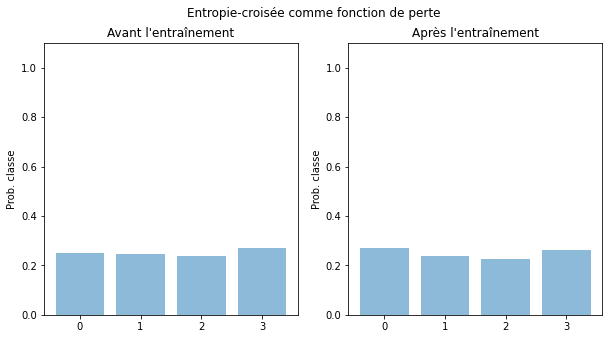

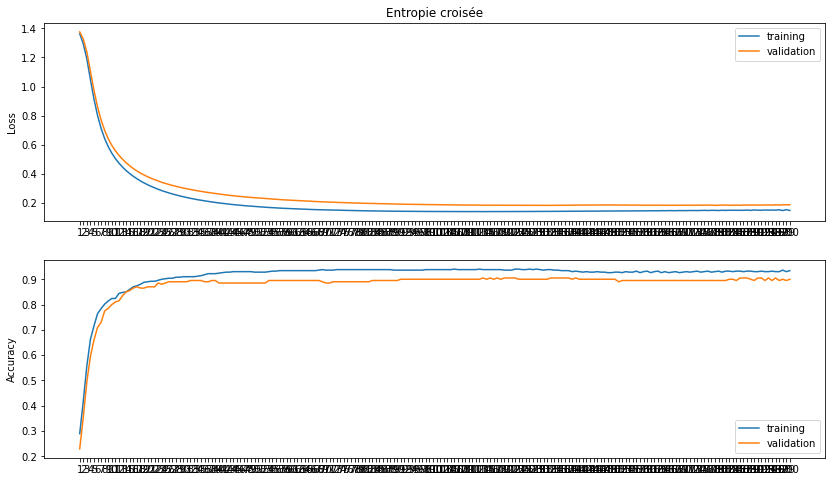

[Training]   Loss: 0.150   Accuracy: 0.934
[Validation] Loss: 0.190   Accuracy: 0.900


In [199]:
# On instancie notre modèle; cette fois-ci avec les données complètes.
num_hidden_neurons = 20
model = TwoLayerClassifier(X_train, y_train, X_val, y_val,  cross_entropy_loss, num_features=2,
                           num_hidden_neurons=num_hidden_neurons, num_classes=num_classes, activation='relu')

# On calcule la prob moyenne pour chaque classe selon les données de test AVANT l'entraînement
before_train_test_scores = np.array([softmax(model.net.forward(x)) for x in X_test]).mean(axis=0)  # Classifier chaque point de la grille

y_pos = np.arange(num_classes)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle("Entropie-croisée comme fonction de perte")

axes[0].bar(y_pos, before_train_test_scores, align='center', alpha=0.5)
axes[0].set_ylabel('Prob. classe')
axes[0].set_ylim(0, 1.1)
axes[0].set_title('Avant l\'entraînement')

# On entraîne

loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=200, lr=1e-2, l2_reg=0.0,
                                                                                 momentum=0.5)


# On calcule la prob moyenne pour chaque classe selon les données de test APRÈS l'entraînement
after_train_test_scores = np.array([softmax(model.net.forward(x)) for x in X_test]).mean(axis=0)  # Classifier chaque point de la grille

axes[1].bar(y_pos, after_train_test_scores, align='center', alpha=0.5)
axes[1].set_ylabel('Prob. classe')
axes[1].set_ylim(0, 1.1)
axes[1].set_title('Après l\'entraînement')

# Illustration de la loss et de l'accuracy (le % de biens classés) à chaque itération     
utils.plot_curves(loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve, title="Entropie croisée")

print('[Training]   Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_train_curve[-1], accu_train_curve[-1]))
print('[Validation] Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_val_curve[-1], accu_val_curve[-1]))

plt.show()

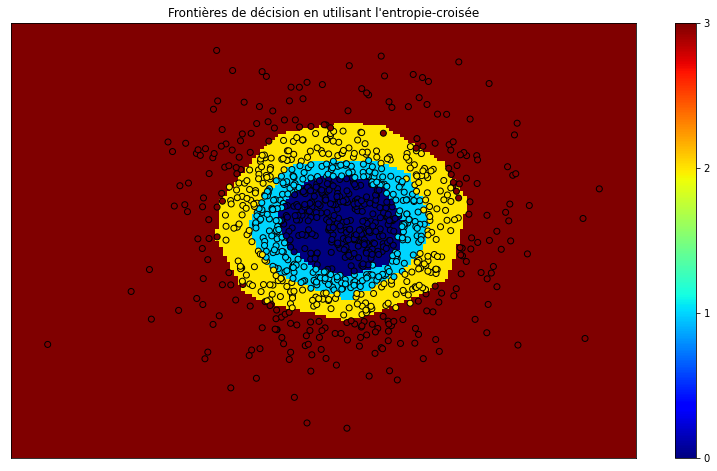

In [200]:
# Visualisation des résultats

h = 0.05  # contrôle la résolution de la grille
x_min, x_max = X_[:, 0].min() - .5, X_[:, 0].max() + .5  # Limites de la grille
y_min, y_max = X_[:, 1].min() - .5, X_[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))  # Créer la grille

X_predict = np.c_[xx.ravel(), yy.ravel()]  # Convertir la grille en une liste de points
Z = model.predict(X_predict)  # Classifier chaque point de la grille
Z = Z.reshape(xx.shape)  # Remettre en 2D

plt.figure(figsize=(14, 8))
im = plt.pcolormesh(xx, yy, Z, cmap='jet', shading='nearest')  # Colorier les cases selon les prédictions
plt.colorbar(im, ticks=[0, 1, 2, 3])

X_plot, y_plot = X_, y_
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, edgecolors='k', cmap='jet')  # Tracer les données

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.title('Frontières de décision en utilisant l\'entropie-croisée')
plt.show()

# Entraînement avec l'entropie


L'entropie $E_{E}$ est définie par 

$$E_{E} = -\sum_c y_c(x) \log y_c(x) = -Y \log Y(x)$$


Pour mettre à jour les poids $W$ dans la bonne direction, il est nécessaire de dériver $E_{E}$ par rapport à $W$.

$$\frac{\partial E_{E}}{\partial W} = \frac{\partial E_{E}}{\partial Y(x)}\frac{\partial Y(x)}{\partial f(x)}\frac{\partial f(x)}{\partial W},$$

Puisque nous avons déjà $\frac{\partial Y(x)}{\partial f(x)}$ et $\frac{\partial f(x)}{\partial W}$, il ne nous reste qu'à trouver $\frac{\partial E_{E}}{\partial Y(x)}$:

$$\begin{aligned}
    \frac{\partial E_{E}}{\partial Y(x)} &= \frac{\partial -Y(x) \log Y(x)}{\partial Y(x)} \\
                                         &= \frac{\partial -Y(x)}{\partial Y(x)} \log Y(x) + Y(x) + \frac{\partial \log Y(x)}{\partial Y(x)} \\
                                         &= -\log Y(x) + Y(x) \frac{1}{Y(x)} \\
                                         &= -\log Y(x) + 1
  \end{aligned}
$$




Ainsi, nous pouvons obtenir la dérivée de l'entropie e par rapport aux poids

$$ \frac{\partial E_{E}}{\partial W} = -\log Y(x) + 1 \cdot J_f(Y) \cdot x $$


Maintenant, implémentons ceci et vérifions que ça fonctionne: Alors que la cross-entropie agit comme une fonction d'erreur typique, l'entropie ne devrait pas avoir d'impact particulier sur l'accuracy, ou en tout cas ne devrait pas l'augmenter. Plutôt, l'entropie de la sortie softmax devrait diminuer progressivement durant l'entraînement. Voyons voir.

In [201]:
# Tout d'abord, quelques fonctions.

def entropy(scores, t):
    # Does not use 't'
    return np.sum(-scores * np.log(scores + 1e-10))

def entropy_derivative(scores, t):
    return -np.log(scores + 1e-10) + 1
    
def entropy_loss(self, scores, y):
    t = np.zeros(len(scores))
    t[y] = 1.

    class_prob = softmax(scores)
    loss = entropy(class_prob, t)

    dent_dsoft = entropy_derivative(class_prob, t)
    dsoft_dscores = softmax_derivatives(class_prob)
    dloss_dscores = dloss_chain(
        dent_dsoft, dsoft_dscores)

    # Regularization cost
    for w in zip(self.parameters):
        loss += 0.5 * self.l2_reg * np.sum(np.square(w))

    return loss, dloss_dscores


In [202]:
# Vérifier que la sortie du réseau initialisé au hasard donne bien une prédiction égale pour chaque classe
num_hidden_neurons = 10
model = TwoLayerClassifier(X_train, y_train, X_val, y_val, entropy_loss,
                           num_features=2, num_hidden_neurons=num_hidden_neurons, num_classes=num_classes)

# 2. Appeler la fonction qui calcule l'accuracy et la loss moyenne pour l'ensemble des données d'entraînement
_, loss = model.global_accuracy_and_loss(X_train,y_train,0)

# 3. Comparer au résultat attendu
scores_equal = np.array([1/num_classes] * num_classes)
loss_attendu = entropy(scores_equal, None) # résultat aléatoire attendu soit -log(1/nb_classes)
print('Sortie: {}  Attendu: {}'.format(loss, loss_attendu))

Sortie: 1.3803616699541668  Attendu: 1.3862943607198905


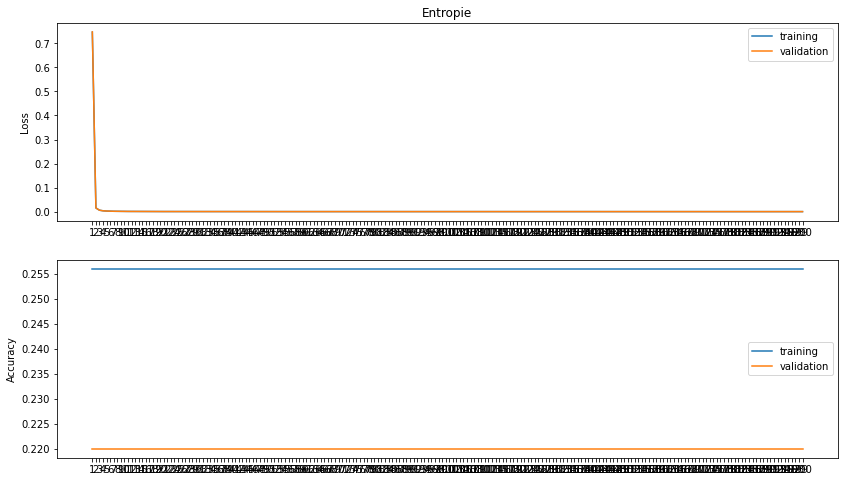

[Training]   Loss: 0.000   Accuracy: 0.256
[Validation] Loss: 0.000   Accuracy: 0.220


In [203]:
# On instancie notre modèle avec les données complètes.
num_hidden_neurons = 20
model = TwoLayerClassifier(X_train, y_train, X_val, y_val,  entropy_loss, num_features=2,
                           num_hidden_neurons=num_hidden_neurons, num_classes=num_classes, activation='relu')

loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=200, lr=1e-2, l2_reg=0.0,
                                                                                 momentum=0.5)

# Illustration de la loss et de l'accuracy (le % de biens classés) à chaque itération     
utils.plot_curves(loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve, title="Entropie")

print('[Training]   Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_train_curve[-1], accu_train_curve[-1]))
print('[Validation] Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_val_curve[-1], accu_val_curve[-1]))

On peut s'appercevoir que la loss décroit, et que l'entropie du softmax coverge vers zéro. Comment visualiser l'effet de cet entraînement ? Une façon serait de visualiser la probabilité de chaque classe en moyenne avant et après l'entraînement. Alors que la probabilité devrait être égale partout avant, la probabilité devrait être autour de 1 pour une, et zéro pour le reste. Voyons voir.  

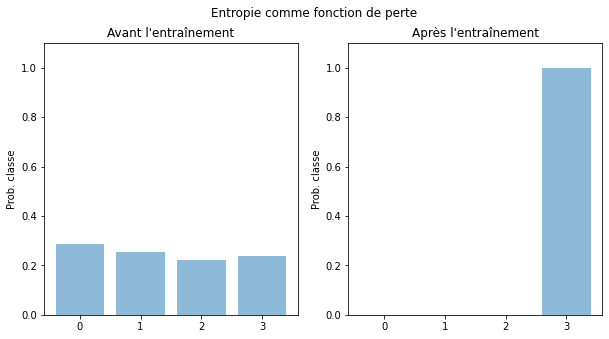

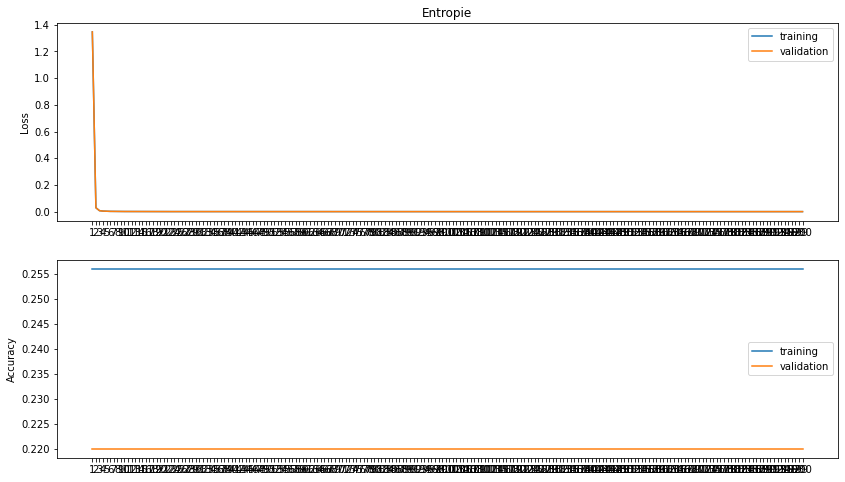

[Training]   Loss: 0.000   Accuracy: 0.256
[Validation] Loss: 0.000   Accuracy: 0.220


In [204]:
model = TwoLayerClassifier(X_train, y_train, X_val, y_val,  entropy_loss, num_features=2,
                           num_hidden_neurons=num_hidden_neurons, num_classes=num_classes, activation='relu')

# On calcule la prob moyenne pour chaque classe selon les données de test AVANT l'entraînement
before_train_test_scores = np.array([softmax(model.net.forward(x)) for x in X_test]).mean(axis=0)  # Classifier chaque point de la grille

y_pos = np.arange(num_classes)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle("Entropie comme fonction de perte")

axes[0].bar(y_pos, before_train_test_scores, align='center', alpha=0.5)
axes[0].set_ylabel('Prob. classe')
axes[0].set_ylim(0, 1.1)
axes[0].set_title('Avant l\'entraînement')

# On entraîne
loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=200, lr=1e-2, l2_reg=0.0,
                                                                                 momentum=0.5)

# On calcule la prob moyenne pour chaque classe selon les données de test APRÈS l'entraînement
after_train_test_scores = np.array([softmax(model.net.forward(x)) for x in X_test]).mean(axis=0)  # Classifier chaque point de la grille

axes[1].bar(y_pos, after_train_test_scores, align='center', alpha=0.5)
axes[1].set_ylabel('Prob. classe')
axes[1].set_ylim(0, 1.1)
axes[1].set_title('Après l\'entraînement')

# Illustration de la loss et de l'accuracy (le % de biens classés) à chaque itération     
utils.plot_curves(loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve, title="Entropie")

print('[Training]   Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_train_curve[-1], accu_train_curve[-1]))
print('[Validation] Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_val_curve[-1], accu_val_curve[-1]))

plt.show()

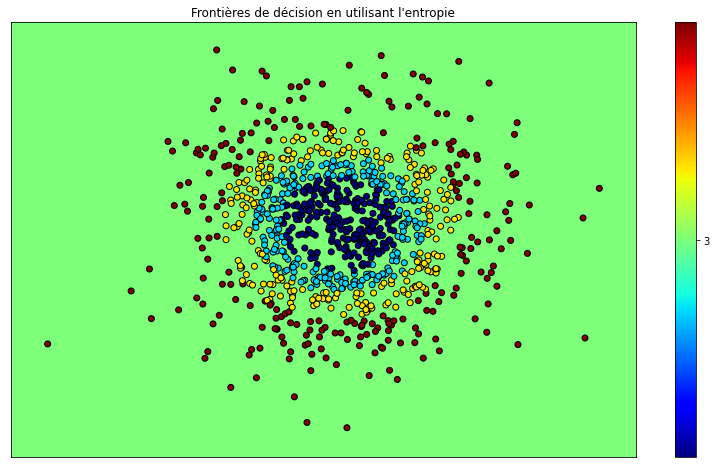

In [205]:
# Visualisation des résultats

h = 0.05  # contrôle la résolution de la grille
x_min, x_max = X_[:, 0].min() - .5, X_[:, 0].max() + .5  # Limites de la grille
y_min, y_max = X_[:, 1].min() - .5, X_[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))  # Créer la grille

X_predict = np.c_[xx.ravel(), yy.ravel()]  # Convertir la grille en une liste de points
Z = model.predict(X_predict)  # Classifier chaque point de la grille
Z = Z.reshape(xx.shape)  # Remettre en 2D

plt.figure(figsize=(14, 8))
im = plt.pcolormesh(xx, yy, Z, cmap='jet', shading='nearest')  # Colorier les cases selon les prédictions
plt.colorbar(im, ticks=[0, 1, 2, 3])

X_plot, y_plot = X_, y_
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, edgecolors='k', cmap='jet')  # Tracer les données

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.title('Frontières de décision en utilisant l\'entropie')
plt.show()

# Entraînement avec l'information

La fonction de coût d'information $E_{I}$ est définie par 

$$E_{I} = -\sum_c \log y_c(x) = -\log Y(x)$$

Pour mettre à jour les poids $W$ dans la bonne direction, il est nécessaire de dériver $E_{I}$ par rapport à $W$.

$$\frac{\partial E_{I}}{\partial W} = \frac{\partial E_{I}}{\partial Y(x)}\frac{\partial Y(x)}{\partial f(x)}\frac{\partial f(x)}{\partial W},$$

Puisque nous avons déjà $\frac{\partial Y(x)}{\partial f(x)}$ et $\frac{\partial f(x)}{\partial W}$, il ne nous reste qu'à trouver $\frac{\partial E_{I}}{\partial Y(x)}$:

$$\begin{aligned}
    \frac{\partial E_{I}}{\partial Y(x)} &= \frac{\partial -\log Y(x)}{\partial Y(x)} \\
                                         &= -\frac{1}{Y(x)}
  \end{aligned}
$$

Ainsi, nous pouvons obtenir la dérivée de l'information par rapport aux poids

$$ \frac{\partial E_{E}}{\partial W} = -\frac{1}{Y(x)} \cdot J_f(Y) \cdot x $$


Maintenant, implémentons ceci et vérifions que ça fonctionne: Alors que la cross-entropie agit comme une fonction d'erreur typique, et que l'entropie force une classe à être prédite tout le temps, l'information ne devrait pas varier grandement durant l'entraînement. En effet, un réseau non-entraîné prédit déjà une probabilité plus-ou-moins égale pour chaque classe. Minimiser l'information en sortie du softmax devrait forcer le réseau à prédire également toutes les classes, maximisant l'entropie.

In [206]:
# Tout d'abord, quelques fonctions.

def information(scores, t):
    # Does not use 't'
    return -np.sum(np.log(scores + 1e-10))

def information_derivative(scores, t):
    return -1/(scores + 1e-10)
    
def information_loss(self, scores, y):
    t = np.zeros(len(scores))
    t[y] = 1.

    class_prob = softmax(scores)
    loss = information(class_prob, t)

    dinf_dsoft = information_derivative(class_prob, t)
    dsoft_dscores = softmax_derivatives(class_prob)
    dloss_dscores = dloss_chain(
        dinf_dsoft, dsoft_dscores)

    # Regularization cost
    for w in zip(self.parameters):
        loss += 0.5 * self.l2_reg * np.sum(np.square(w))

    return loss, dloss_dscores


In [207]:
# Vérifier que la sortie du réseau initialisé au hasard donne bien une prédiction égale pour chaque classe
num_hidden_neurons = 10
model = TwoLayerClassifier(X_train, y_train, X_val, y_val, information_loss,
                           num_features=2, num_hidden_neurons=num_hidden_neurons, num_classes=num_classes)

# 2. Appeler la fonction qui calcule l'accuracy et la loss moyenne pour l'ensemble des données d'entraînement
_, loss = model.global_accuracy_and_loss(X_train,y_train,0)

# 3. Comparer au résultat attendu
scores_equal = np.array([1/num_classes] * num_classes)
loss_attendu = information(scores_equal, None) # résultat aléatoire attendu soit -log(1/nb_classes)
print('Sortie: {}  Attendu: {}'.format(loss, loss_attendu))

Sortie: 5.556072611467796  Attendu: 5.545177442879562


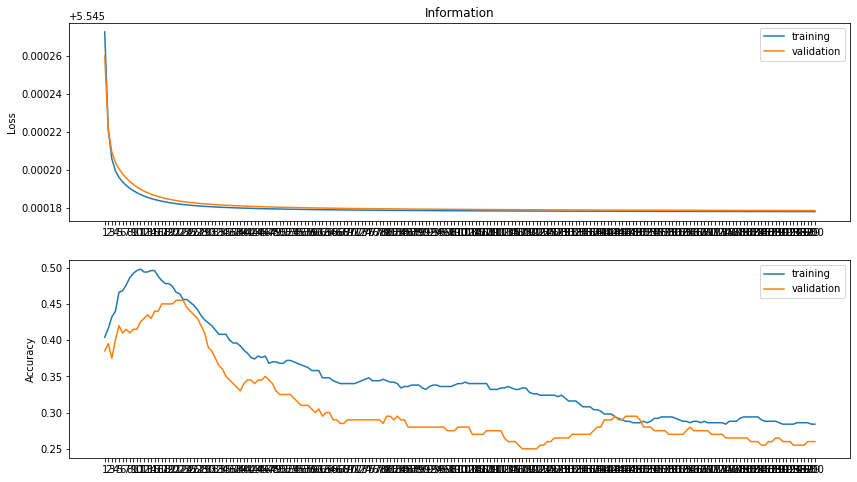

[Training]   Loss: 5.545   Accuracy: 0.284
[Validation] Loss: 5.545   Accuracy: 0.260


In [208]:
# On instancie notre modèle avec les données complètes.
num_hidden_neurons = 20
model = TwoLayerClassifier(X_train, y_train, X_val, y_val,  information_loss, num_features=2,
                           num_hidden_neurons=num_hidden_neurons, num_classes=num_classes, activation='relu')

loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=200, lr=1e-2, l2_reg=0.0,
                                                                                 momentum=0.5)

# Illustration de la loss et de l'accuracy (le % de biens classés) à chaque itération     
utils.plot_curves(loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve, title="Information")

print('[Training]   Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_train_curve[-1], accu_train_curve[-1]))
print('[Validation] Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_val_curve[-1], accu_val_curve[-1]))

On peut voir que la loss décroit légèrement (voir l'échelle), et que la somme de l'information du softmax coverge vers une valeur. Comment visualiser l'effet de cet entraînement ? Une façon serait de visualiser la probabilité de chaque classe en moyenne avant et après l'entraînement. En minimisant l'information, l'entropie devrait devenir égale pour chaque classe. Voyons voir.  

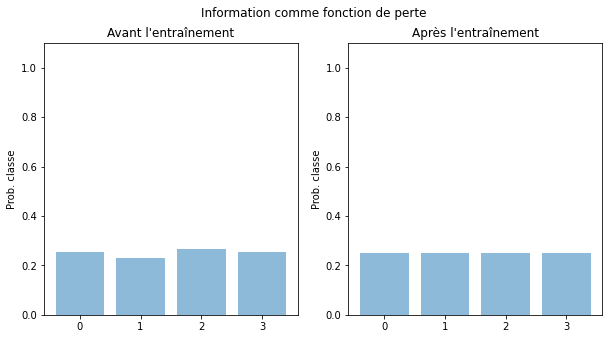

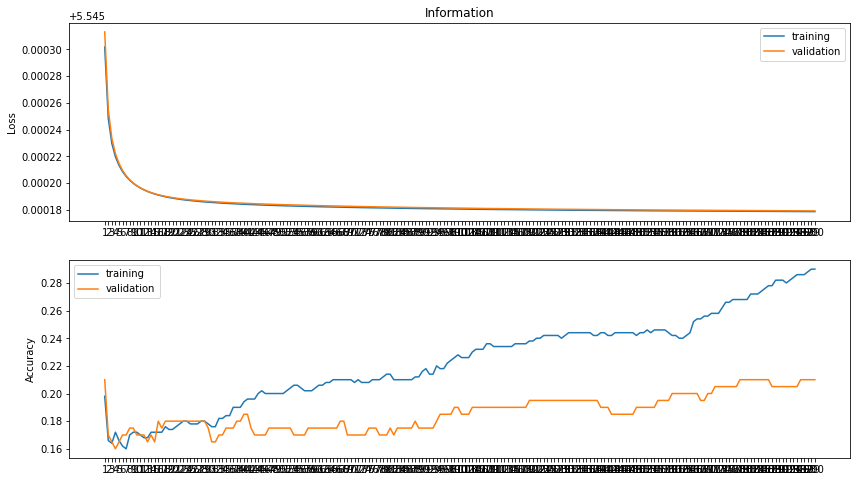

[Training]   Loss: 5.545   Accuracy: 0.290
[Validation] Loss: 5.545   Accuracy: 0.210


In [209]:
model = TwoLayerClassifier(X_train, y_train, X_val, y_val,  information_loss, num_features=2,
                           num_hidden_neurons=num_hidden_neurons, num_classes=num_classes, activation='relu')

# On calcule la prob moyenne pour chaque classe selon les données de test AVANT l'entraînement
before_train_test_scores = np.array([softmax(model.net.forward(x)) for x in X_test]).mean(axis=0)  # Classifier chaque point de la grille

y_pos = np.arange(num_classes)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle("Information comme fonction de perte")

axes[0].bar(y_pos, before_train_test_scores, align='center', alpha=0.5)
axes[0].set_ylabel('Prob. classe')
axes[0].set_ylim(0, 1.1)
axes[0].set_title('Avant l\'entraînement')

# On entraîne
loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=200, lr=1e-2, l2_reg=0.0,
                                                                                 momentum=0.5)

# On calcule la prob moyenne pour chaque classe selon les données de test APRÈS l'entraînement
after_train_test_scores = np.array([softmax(model.net.forward(x)) for x in X_test]).mean(axis=0)  # Classifier chaque point de la grille

axes[1].bar(y_pos, after_train_test_scores, align='center', alpha=0.5)
axes[1].set_ylabel('Prob. classe')
axes[1].set_ylim(0, 1.1)
axes[1].set_title('Après l\'entraînement')

# Illustration de la loss et de l'accuracy (le % de biens classés) à chaque itération     
utils.plot_curves(loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve, title="Information")

print('[Training]   Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_train_curve[-1], accu_train_curve[-1]))
print('[Validation] Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_val_curve[-1], accu_val_curve[-1]))

plt.show()

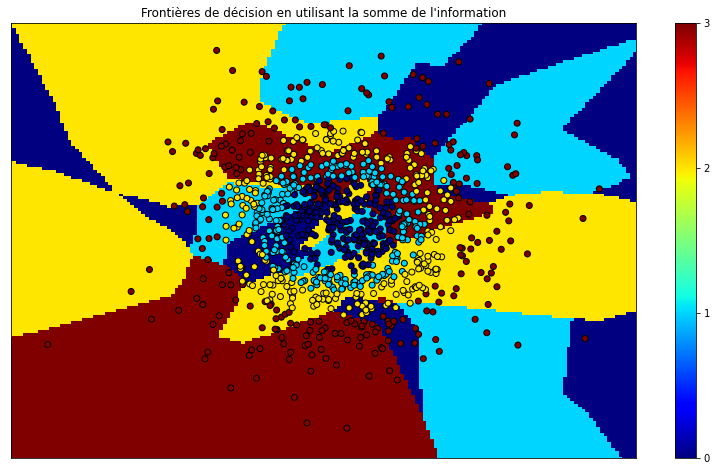

In [210]:
# Visualisation des résultats

h = 0.05  # contrôle la résolution de la grille
x_min, x_max = X_[:, 0].min() - .5, X_[:, 0].max() + .5  # Limites de la grille
y_min, y_max = X_[:, 1].min() - .5, X_[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))  # Créer la grille

X_predict = np.c_[xx.ravel(), yy.ravel()]  # Convertir la grille en une liste de points
Z = model.predict(X_predict)  # Classifier chaque point de la grille
Z = Z.reshape(xx.shape)  # Remettre en 2D

plt.figure(figsize=(14, 8))
im = plt.pcolormesh(xx, yy, Z, cmap='jet', shading='nearest')  # Colorier les cases selon les prédictions
plt.colorbar(im, ticks=[0, 1, 2, 3])

X_plot, y_plot = X_, y_
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, edgecolors='k', cmap='jet')  # Tracer les données

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.title('Frontières de décision en utilisant la somme de l\'information')
plt.show()